In [1]:
!pip install gdown

# Importing Libraries

In [2]:
import gdown
import pandas as pd
import matplotlib.pyplot as plt

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_scheduler, Trainer, TrainingArguments

from tqdm.auto import tqdm

# Importing Data

In [3]:
gdown.download("https://drive.google.com/uc?id=12OqvVFIDZcs1MsG8wJMbu-3zGKEKCLNy", '/kaggle/working/data.csv', quiet=False)
print('/kaggle/working/data.csv')

Downloading...
From: https://drive.google.com/uc?id=12OqvVFIDZcs1MsG8wJMbu-3zGKEKCLNy
To: /kaggle/working/data.csv
100%|██████████| 736k/736k [00:00<00:00, 107MB/s]

/kaggle/working/data.csv


In [4]:
df = pd.read_csv("/kaggle/working/data.csv")
df.head()

,text,comp,en1,en2
0,لابتوب اسوس افضل من لابتوبات ابل ؟ احس مستحيل ...,1,اسوس,ابل
1,اسوس افضل من وجهة نظري,1,اسوس,NaN
2,كلهم نفس المواصفات مافي فرق اسوس افضل من hp في...,1,اسوس,hp
3,التخصصات الهندسية بالذات الحاسب والبرمجيات ماي...,1,اسوس,NaN
4,اسوس افضل من ناحية التنوع والاسعار والعروض,1,اسوس,NaN


# Data Preprocessing

In [5]:
# Split the dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["comp"], random_state=42)

In [6]:
# Convert pandas DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [7]:
model_name = "aubmindlab/bert-base-arabertv02-twitter"

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
max_length = max(len(tokenizer(text)["input_ids"]) for text in com['text'])
max_length

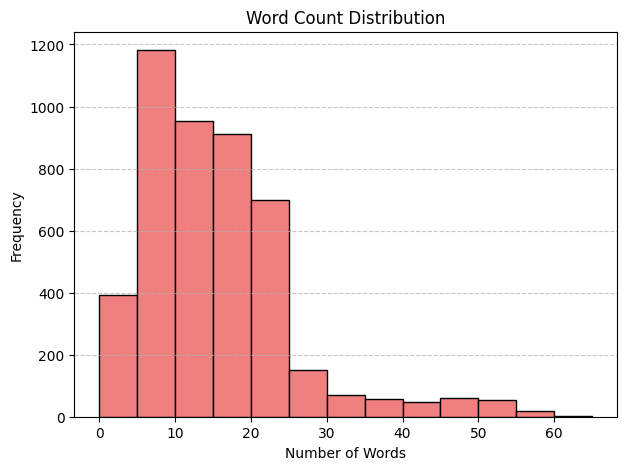

In [8]:
# Calculate word counts
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Define bin size and ranges
bins = range(0, df['word_count'].max() + 5, 5)

plt.figure(figsize=(7,5))
plt.hist(df['word_count'], bins=bins, color='lightcoral', edgecolor='black')
plt.title('Word Count Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Drop count column
df = df.drop(columns=['word_count'])

In [9]:
max_len = 30

In [10]:
# Tokenization function (based on your previous one)
def tokenize_data(example):
    text = example["text"]
    # Tokenizing the text with padding, truncation, and max_length
    tokens = tokenizer(text, padding="max_length", truncation=True, max_length=max_len)
    
    # Use the 'comp' column as the label
    label = example["comp"]
    
    # Add the label to the tokenized output
    tokens["label"] = label
    
    return tokens

In [11]:
train_dataset = train_dataset.map(tokenize_data, batched=False)
test_dataset = test_dataset.map(tokenize_data, batched=False)

Map:   0%|          | 0/3679 [00:00<?, ? examples/s]

Map:   0%|          | 0/920 [00:00<?, ? examples/s]

In [12]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [13]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# AraBERT

In [14]:
optimizer = AdamW(model.parameters(), lr=7e-6, eps=1e-8, weight_decay= 0.7)
epochs = 10
num_training_steps = len(train_loader) * epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [15]:
for param in model.parameters():
    param.requires_grad = False

for param in model.bert.encoder.layer[-2:].parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print(device)

cuda


In [17]:
from sklearn.metrics import f1_score
import torch
from torch.utils.data import DataLoader

# Initialize lists to track losses and F1 scores
train_losses, test_losses = [], []
train_f1_scores, test_f1_scores = [], []

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0
    all_train_preds = []
    all_train_labels = []
    
    # Training phase
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update metrics
        total_train_loss += loss.item()
        preds = torch.argmax(logits, dim=-1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())
        
    # Calculate training metrics
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_f1 = f1_score(all_train_labels, all_train_preds, average="macro", zero_division=0)
    train_f1_scores.append(train_f1)

    # Validation phase
    model.eval() 
    total_test_loss = 0
    all_test_preds = []
    all_test_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass (no gradients in eval mode)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            # Update metrics
            total_test_loss += loss.item()
            preds = torch.argmax(logits, dim=-1)
            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_f1 = f1_score(all_test_labels, all_test_preds, average="macro", zero_division=0)
    test_f1_scores.append(test_f1)

    # Print metrics for the current epoch
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train F1: {train_f1:.4f}")
    print(f"Test Loss: {avg_test_loss:.4f}, Test F1: {test_f1:.4f}")
    
    # Adjust learning rate scheduler
    lr_scheduler.step()

Epoch 1/10
Train Loss: 0.4820, Train F1: 0.8015
Test Loss: 0.2127, Test F1: 0.9500
Epoch 2/10
Train Loss: 0.1347, Train F1: 0.9619
Test Loss: 0.0777, Test F1: 0.9750
Epoch 3/10
Train Loss: 0.0957, Train F1: 0.9685
Test Loss: 0.0703, Test F1: 0.9750
Epoch 4/10
Train Loss: 0.0861, Train F1: 0.9696
Test Loss: 0.0638, Test F1: 0.9772
Epoch 5/10
Train Loss: 0.0773, Train F1: 0.9728
Test Loss: 0.0588, Test F1: 0.9837
Epoch 6/10
Train Loss: 0.0695, Train F1: 0.9766
Test Loss: 0.0629, Test F1: 0.9761
Epoch 7/10
Train Loss: 0.0624, Train F1: 0.9777
Test Loss: 0.0545, Test F1: 0.9804
Epoch 8/10
Train Loss: 0.0569, Train F1: 0.9812
Test Loss: 0.0565, Test F1: 0.9837
Epoch 9/10
Train Loss: 0.0510, Train F1: 0.9823
Test Loss: 0.0542, Test F1: 0.9815
Epoch 10/10
Train Loss: 0.0462, Train F1: 0.9829
Test Loss: 0.0518, Test F1: 0.9826


# Evaluation

In [18]:
# Evaluation loop
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)

        all_preds.extend(preds.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average=None, labels=[0, 1], zero_division=0)
recall = recall_score(all_labels, all_preds, average=None, labels=[0, 1], zero_division=0)
Avg_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
f1 = f1_score(all_labels, all_preds, average=None, labels=[0, 1], zero_division=0)

print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test Avg F1 Score: {Avg_f1}")
print(f"Test F1 Score: {f1}")

Test Accuracy: 0.9826086956521739
Test Precision: [0.97816594 0.98701299]
Test Recall: [0.98678414 0.97854077]
Test Avg F1 Score: 0.9826073805202662
Test F1 Score: [0.98245614 0.98275862]


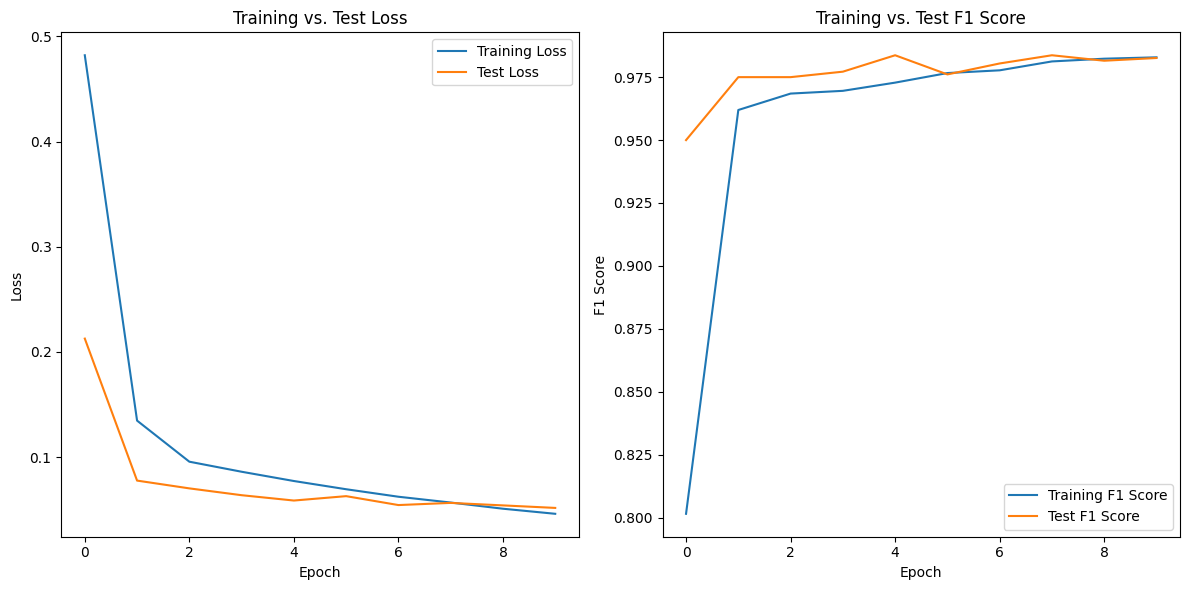

In [19]:
# Plot learning curves
plt.figure(figsize=(12, 6))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Test Loss")
plt.legend()

# F1 Score curves
plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label="Training F1 Score")
plt.plot(test_f1_scores, label="Test F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Training vs. Test F1 Score")
plt.legend()

plt.tight_layout()
plt.show()

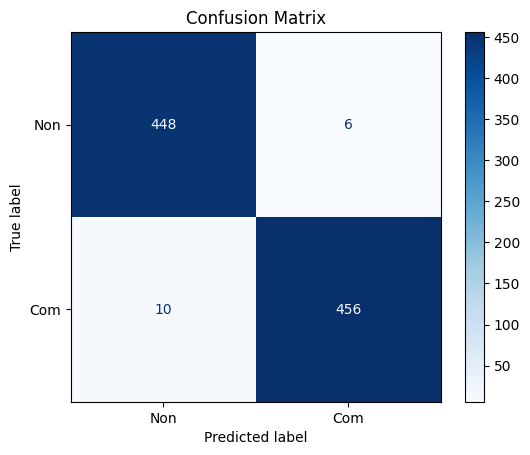

In [20]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non", "Com"])

# Plot
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()